In [44]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import optuna
import seaborn as sns

In [45]:
# load in 2022 mlb season data

df = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_processed.csv")

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_processed.csv")

In [46]:
# load in linear weights for events

linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [47]:
# load in calculated expected metrics

xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\pfx_2022&3_xpfx.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\IVB_2022&3_xpfz.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\axis_2022&3_xaxis.csv")

xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\swing_2022&3_xswing.csv")
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\whiff_2022&3_xwhiff.csv")
xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\fb_2022&3_xfb.csv")
xgrb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\gb_2022&3_xgb.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\ld_2022&3_xld.csv")
xfoul = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\foul_2022&3_xfoul.csv")
xcs = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\cs_2022&3_xcalledstrike.csv")
diff2022 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\2022_diffs.csv")
diff2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\off_speed\2023_diffs.csv")

In [48]:
# rename and drop columns from expected dfs

xpfx_x = xpfx_x[['pitch_id_raw', 'xpfx_x']]
xpfx_z = xpfx_z[['pitch_id_raw', 'xpfx_z']]
xspin_axis = xspin_axis[['pitch_id_raw', 'diff']]
xswing = xswing[['pitch_id_raw', 'xswing']]
xwhiff = xwhiff[['pitch_id_raw', 'xwhiff']]
xfb = xfb[['pitch_id_raw', 'xfb']]
xgrb = xgrb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'xld']]
xfoul = xfoul[['pitch_id_raw', 'xfoul']]
xcs = xcs[['pitch_id_raw', 'xcs']]
diffs = pd.concat([diff2022, diff2023], axis=0)
diffs = diffs[['pitch_id_raw', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed']]

In [49]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only offspeed

df = df[df['pitch_type'].isin(['CH', 'FS'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [50]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only offspeed

df_2023 = df_2023[df_2023['pitch_type'].isin(['CH', 'FS'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df.loc[df['p_throws'] == 'L', 'spin_axis'] = 360 - df['spin_axis']

# total movement column
df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column
df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [ ]:
pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "SP",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN", "FA": "FF", "FT": "SI"
    }

df_2023['pitch_type'] = df_2023['pitch_type'].map(pitch_type_map)
df['pitch_type'] = df['pitch_type'].map(pitch_type_map)

In [51]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [52]:
# function for using mappings to determine outcome

def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# apply function to each row

df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [53]:
# drop na outcome rows

df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [54]:
# create outcome label encoder

outcome_encoder = LabelEncoder()

# get all possible outcome values

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

# label encode the outcome column

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [55]:
# perform left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')
df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgrb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')
df = pd.merge(df, xfoul, on='pitch_id_raw', how='left')
df = pd.merge(df, xcs, on='pitch_id_raw', how='left')
df = pd.merge(df, diffs, on='pitch_id_raw', how='left')

In [56]:
# perform left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgrb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfoul, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xcs, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, diffs, on='pitch_id_raw', how='left')

In [57]:
# convert all negative swing probabilities to zero (bug)

df.loc[df['xswing'] < 0, 'xswing'] = 0
df_2023.loc[df_2023['xswing'] < 0, 'xswing'] = 0

In [58]:
# create combination term of swing and whiff probabilities

df['swing_whiff'] = df['xswing'] * df['xwhiff']
df_2023['swing_whiff'] = df_2023['xswing'] * df_2023['xwhiff']

In [60]:
# feature selection and data splitting

columns = ['outcome', 'player_name', 'pitch_type', 'spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xwhiff', 'xswing', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'delta_run_exp', 'rolling_avg_velo', 'diff_spin_axis',\
           'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed']

features = ['spin_axis', 'ax', 'vz0', 'az', 'vx0', 'ay', 'vy0', 'release_speed', 'release_pos_x', 'release_pos_y', \
           'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_z', 'pfx_x', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio',\
           'xpfx_x', 'xpfx_z', 'diff', 'xwhiff', 'xswing', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs', 'rolling_avg_velo', 'diff_spin_axis',\
            'diff_pfx_x', 'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed']

# drop any rows with nan values

df = df[columns]
df = df.dropna()

# create features and targets

X = df[features]
y = df['outcome']

In [61]:
# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# optuna tuning block

#def objective(trial):
    
    # define hyperparameters
    
    #params = {
        #'max_depth': trial.suggest_int('max_depth', 3, 9),
        #'learning_rate': trial.suggest_float('eta', 0.01, 0.3),
        #'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        #'objective': 'multi:softmax',
        #'num_class': len(np.unique(y_train)),
        #'eval_metric': 'mlogloss',
        #'use_label_encoder': False
    #}

    # initialize model
    
    #model = xgb.XGBClassifier(**params, n_estimators=100)

    # train the model
    
    #model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False)

    # predict on validation set
    
    #y_valid_pred = model.predict_proba(X_valid)

    # calculate log loss on the validation set
    
    #loss = log_loss(y_valid, y_valid_pred)

    #return loss

#create an optuna study and specifcy the the direction of the optimization

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

# print best parameters

#print(study.best_params)

In [63]:
# set up model

params = {
        'max_depth': 6,
        'eta': 0.1044289896836109,
        'subsample': 0.8838491939084707,
        'colsample_bytree': 0.9518679684601651,
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

# initialize model
    
model = xgb.XGBClassifier(**params, n_estimators=100)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9518679684601651, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1044289896836109,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=11,
              num_parallel_tree=None, ...)

In [64]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.48904948419484745
Confusion Matrix:
[[6123    0    0   45  269    0    3  392   23    0    0]
 [  29    6    0   65   45    0   58   47    0    0    0]
 [  33    0    0    8   34    0    3   38    0    0    0]
 [ 507    7    0  188  784    0   94  736    5    0    0]
 [ 812    2    0  136  997    0   14  995   29    0    0]
 [  11    0    0   10   41    0    3   54    0    0    0]
 [ 181    6    0  138  146    0  128  139    2    0    0]
 [ 926    0    0  156  777    0   11 1404   11    0    0]
 [ 619    0    0   37  211    0    2  256   19    0    0]
 [   0    0    0    7    2    0    3    2    0    0    0]
 [ 275    0    0    2    5    0    0   16    0    0    0]]


<Figure size 1000x5000 with 0 Axes>

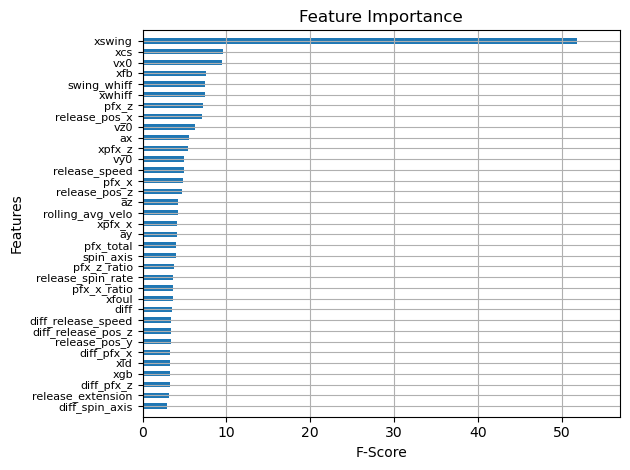

In [65]:
# plot feature importance

plt.figure(figsize=(10, 50))
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('os_feature_importance.png', dpi=300)
plt.show()

In [66]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

xswing: 51.737606048583984
xcs: 9.589237213134766
vx0: 9.530558586120605
xfb: 7.613652229309082
swing_whiff: 7.480998516082764
xwhiff: 7.3912763595581055
pfx_z: 7.233120918273926
release_pos_x: 7.131725788116455
vz0: 6.223917007446289
ax: 5.590841293334961
xpfx_z: 5.455685138702393
vy0: 4.974942207336426
release_speed: 4.963830471038818
pfx_x: 4.797483444213867
release_pos_z: 4.749122142791748
az: 4.187229633331299
rolling_avg_velo: 4.18182897567749
xpfx_x: 4.112770080566406
ay: 4.089543342590332
pfx_total: 4.001787185668945
spin_axis: 3.942718744277954
pfx_z_ratio: 3.756700277328491
release_spin_rate: 3.672653913497925
pfx_x_ratio: 3.622774124145508
xfoul: 3.603468894958496
diff: 3.516204833984375
diff_release_speed: 3.3964486122131348
diff_release_pos_z: 3.391080617904663
release_pos_y: 3.3841958045959473
diff_pfx_x: 3.2954323291778564
xld: 3.253772497177124
xgb: 3.249673366546631
diff_pfx_z: 3.2452619075775146
release_extension: 3.1071081161499023
diff_spin_axis: 2.891033887863159


In [67]:
# copy and keep only features

df_2023_features = df_2023[features]

# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [68]:
# label encode linear weights to match outcome

linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])

In [69]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# weighted sum of each outcome's probability * each outcome's linear weight run value

df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [70]:
def reformat_name(name):
    parts = name.split(', ')
    if len(parts) == 2:
        return parts[1] + ' ' + parts[0]
    else:
        return name

df['player_name'] = df['player_name'].apply(reformat_name)
df_2023['player_name'] = df_2023['player_name'].apply(reformat_name)

In [71]:
# group by player name and pitch type for pitches a player threw more than 100 times

grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 100)

# group by player name and pitch type and get the mean pitch quality

pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# sort the results by pitch quality in descending order and take the top 10

bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# sort the results by pitch quality in ascending order and take the bottom 10

top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# print results

print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
           player_name pitch_type  pitch_quality
89      Félix Bautista         FS      -0.042270
167      Kyle Finnegan         FS      -0.033157
123        Jhoan Duran         FS      -0.031653
240  Shintaro Fujinami         FS      -0.029614
233    Sandy Alcantara         CH      -0.024385
270       Yennier Cano         CH      -0.023519
271     Yonny Chirinos         FS      -0.023444
87      Framber Valdez         CH      -0.023039
198      Michael Wacha         CH      -0.021542
226        Ryan Pepiot         CH      -0.021170

Bottom 10:
        player_name pitch_type  pitch_quality
196  Michael Kopech         CH       0.015588
85       Eury Pérez         CH       0.015171
171     Kyle Muller         CH       0.014125
75       Drew Smith         CH       0.013679
104   Hunter Greene         CH       0.013508
132    Johan Oviedo         CH       0.012025
61   Connor Seabold         CH       0.011185
51    Chris Bassitt         FS       0.011154
141  Jose A. Ferrer        

In [72]:
# determine max and min avg pitch quality values

max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

# create normalized stuff+ metric centered around 100

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']
mean_stuff = pitch_quality_sum['stuff_plus'].mean()
scaling_factor = 100 / mean_stuff
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# sort by stuff plus in ascending order

sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)

# reset index and +1 to get rank column

sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1

# convert to int for rounding

sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)

# print name, pitch type, and stuff plus top 50

sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,Félix Bautista,FS,262
2,Kyle Finnegan,FS,221
3,Jhoan Duran,FS,214
4,Shintaro Fujinami,FS,205
5,Sandy Alcantara,CH,181
6,Yennier Cano,CH,177
7,Yonny Chirinos,FS,177
8,Framber Valdez,CH,175
9,Michael Wacha,CH,168
10,Ryan Pepiot,CH,166


In [73]:
# select top 25 rows

top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# plotting rankings as a table

fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')
ax.set_title('Top 25 Offspeed Stuff+')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center',
                 colWidths=[0.4, 0.2, 0.2])
plt.tight_layout()

# save fig and close

plt.savefig('os_stuff_plus_rankings.png', dpi=300)
plt.close()

In [74]:
# group by pitcher and pitch type

pp = df_2023.groupby(['player_name', 'pitch_type'])

# calculate sum of delta run expectancy and count of pitches for each pitcher's pitch

rv = pp.agg(total_delta_run_exp=('delta_run_exp', 'sum'),
                      total_pitches=('delta_run_exp', 'count'))

# calculate run value per 100 pitches

rv['run_value_per_100_pitches'] = (rv['total_delta_run_exp'] / rv['total_pitches']) * 100

# filter for pitches thrown at least 100 times and sort

rv = rv[rv['total_pitches'] > 100]
rv = rv.sort_values(by='run_value_per_100_pitches')

# merge with sorted pitch quality sum on player name and pitch type

model_validation_df = pd.merge(sorted_pitch_quality_sum, rv, on=['player_name', 'pitch_type'], how='left')

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


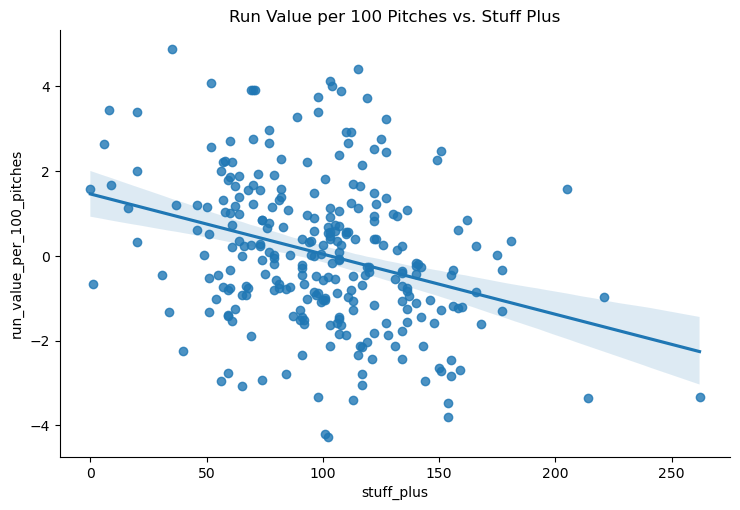

In [75]:
# scatter plot with a regression line

sns.lmplot(x='stuff_plus', y='run_value_per_100_pitches', data=model_validation_df, aspect=1.5)
plt.title('Run Value per 100 Pitches vs. Stuff Plus')
plt.savefig('os_validation_plot_os.png', dpi=300)
plt.show()

In [76]:
# correlation coefficient

correlation = model_validation_df['stuff_plus'].corr(model_validation_df['run_value_per_100_pitches'])
print(f"Correlation Coefficient: {correlation}")


from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

slope, intercept, r_value, p_value, std_err = stats.linregress(model_validation_df['stuff_plus'], model_validation_df['run_value_per_100_pitches'])
predicted_values = slope * model_validation_df['stuff_plus'] + intercept

# mse and rmse

mse = mean_squared_error(model_validation_df['run_value_per_100_pitches'], predicted_values)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# rsquared

r_squared = r2_score(model_validation_df['run_value_per_100_pitches'], predicted_values)
print(f"R-squared: {r_squared}")

Correlation Coefficient: -0.30990471349039883
Mean Squared Error: 2.7906868775723637
Root Mean Squared Error: 1.6705349076186238
R-squared: 0.0960409314435664


In [77]:
# get pitch count for each pitcher's pitches

pitch_counts = df_2023.groupby(['player_name', 'pitch_type']).size()
count_df = pitch_counts.reset_index(name='count')

# merge pitch counts on pitch quality sum to get stuff plus and pitch count on the same df

os_clean = pd.merge(pitch_quality_sum, count_df, on=['player_name', 'pitch_type'], how='left')
os_clean['stuff_plus'] = os_clean['stuff_plus'].astype(int)
os_clean = os_clean[['player_name', 'pitch_type', 'stuff_plus', 'count']]
offspeed_ready = os_clean.sort_values(by='stuff_plus', ascending=False)

In [78]:
# save to y drive

offspeed_ready.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\polished_dfs\offspeed_ready.csv")